In [1]:
# cd CrisisMMD_Dataset

In [2]:
pwd

'/notebooks/CrisisMMD_Dataset'

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from Precision_Module import Precision1

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import aidrtokenize
from sklearn.metrics import classification_report

In [6]:
path = Path('/notebooks/CrisisMMD_Dataset')
# path.ls()

In [7]:
# import tarfile
# zf = tarfile.open("CrisisMMD_v2.tar.gz")
# zf.extractall()

In [8]:
path_img = path/'data_image'

In [9]:
data_file = 'new_task_damage_data.tsv'
if data_file in path.ls():
    data = pd.read_csv(str(data_file),delimiter='\t',encoding='utf-8')
else:
    cal_wlf = pd.read_csv('california_wildfires_final_data.tsv',delimiter='\t',encoding='utf-8')
    hurr_hrv = pd.read_csv('hurricane_harvey_final_data.tsv',delimiter='\t',encoding='utf-8')
    hurr_irm = pd.read_csv('hurricane_irma_final_data.tsv',delimiter='\t',encoding='utf-8')
    hurr_mra = pd.read_csv('hurricane_maria_final_data.tsv',delimiter='\t',encoding='utf-8')
    iran_eq = pd.read_csv('iraq_iran_earthquake_final_data.tsv',delimiter='\t',encoding='utf-8')
    maxico_eq = pd.read_csv('mexico_earthquake_final_data.tsv',delimiter='\t',encoding='utf-8')
    srl_eq = pd.read_csv('srilanka_floods_final_data.tsv',delimiter='\t',encoding='utf-8')
    
    
    data = pd.concat([cal_wlf,hurr_hrv,hurr_irm,hurr_mra,iran_eq,maxico_eq,srl_eq],axis=0).reset_index()
    data = data.drop(['index'],axis=1)
    data = data[data['image_damage'].notnull()==True]
    
    data.to_csv('new_task_damage_data.tsv',encoding='utf-8')

In [10]:
print(f"shape of data: {data.shape}\n")
print(data['image_damage'].value_counts())
print("="*50)

shape of data: (3627, 15)

severe_damage              2212
mild_damage                 839
little_or_no_damage         475
dont_know_or_cant_judge     101
Name: image_damage, dtype: int64


In [11]:
data.head()

tweet_id              image_id    text_info  text_info_conf  \
2  917791291823591425  917791291823591425_0  informative          0.6813   
4  917792092100988929  917792092100988929_0  informative          0.6727   
5  917792147700465664  917792147700465664_0  informative          0.7143   
6  917792930315821057  917792930315821057_0  informative          1.0000   
7  917793137925459968  917793137925459968_0  informative          1.0000   

    image_info  image_info_conf                         text_human  \
2  informative           1.0000         other_relevant_information   
4  informative           0.6612         other_relevant_information   
5  informative           1.0000         other_relevant_information   
6  informative           1.0000             injured_or_dead_people   
7  informative           1.0000  infrastructure_and_utility_damage   

   text_human_conf                        image_human  image_human_conf  \
2           0.6813  infrastructure_and_utility_damage            1.0000   
4           0.6727  infrastructure_and_utility_damage            0.6612   
5           0.7143  infrastructure_and_utility_damage            1.0000   
6           1.0000  infrastructure_and_utility_damage            1.0000   
7           1.0000  infrastructure_and_utility_damage            1.0000   

    image_damage  image_damage_conf  \
2  severe_damage                1.0   
4  severe_damage                1.0   
5  severe_damage                1.0   
6  severe_damage                1.0   
7  severe_damage                1.0   

                                          tweet_text  \
2  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
4  RT @TIME: California's raging wildfires as you...   
5  Wildfires Threaten Californiaâ€™s First Legal ...   
6  Mass Evacuations in California as Wildfires Ki...   
7  RT @KAKEnews: California wildfires destroy mor...   

                                        image_url  \
2  http://pbs.twimg.com/media/DLudaaZV4AAjT7x.jpg   
4  http://pbs.twimg.com/media/DLwNe-NXUAE0XCw.jpg   
5  http://pbs.twimg.com/media/DLynF2KUEAAqCYD.jpg   
6  http://pbs.twimg.com/media/DLym3rJW0AAv4N_.jpg   
7  http://pbs.twimg.com/media/DLtgmEPXUAEo1LV.jpg   

                                          image_path  
2  data_image/california_wildfires/10_10_2017/917...  
4  data_image/california_wildfires/10_10_2017/917...  
5  data_image/california_wildfires/10_10_2017/917...  
6  data_image/california_wildfires/10_10_2017/917...  
7  data_image/california_wildfires/10_10_2017/917...

In [12]:
tfms = get_transforms()

data_img = (ImageList.from_df(data,path,cols='image_path')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols='image_damage')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=224)
        #Data augmentation? -> use tfms with a size of 128
        .databunch()
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

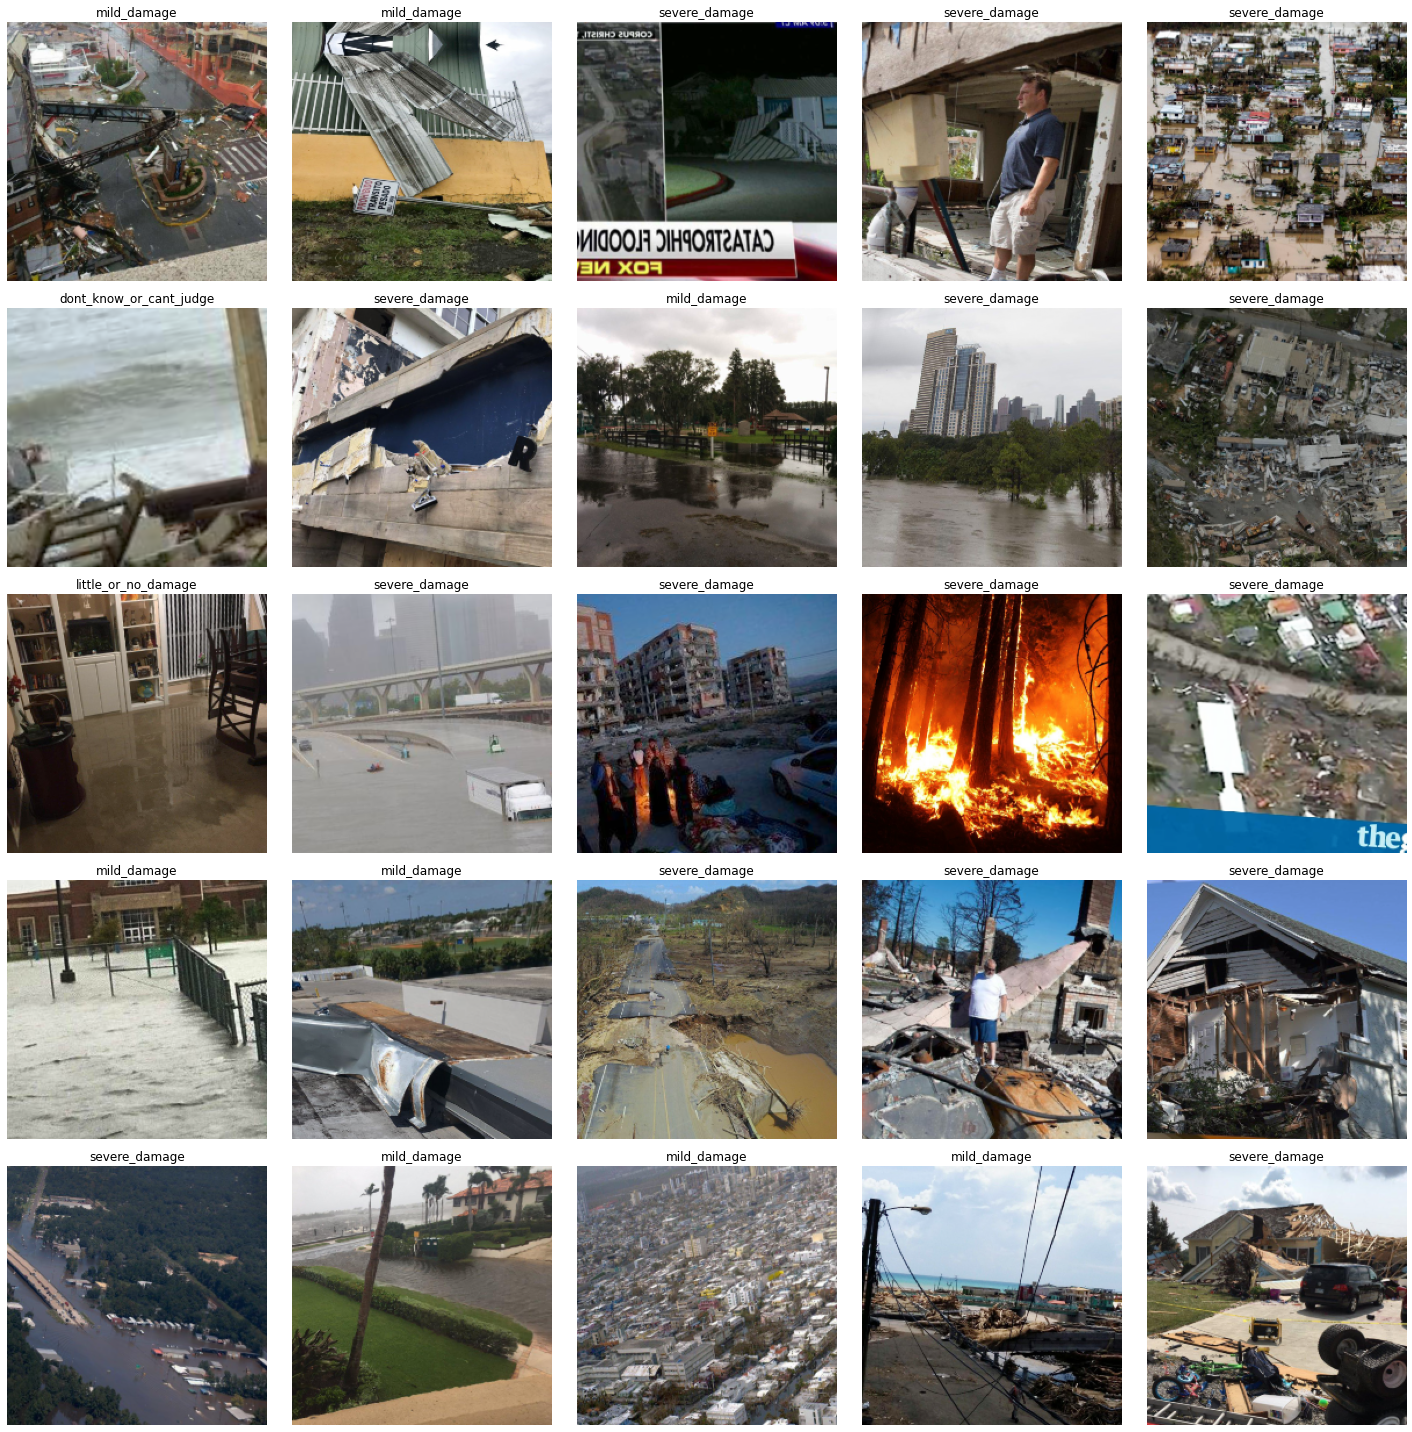

In [13]:
data_img.show_batch()

In [14]:
arch = models.vgg16_bn
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [15]:
# learn_img.model

In [16]:
learn_img.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


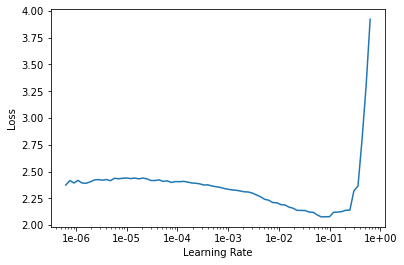

In [17]:
learn_img.recorder.plot()

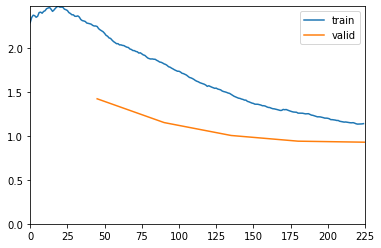

In [18]:
lr = 0.001
learn_img.fit_one_cycle(5, slice(lr),wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


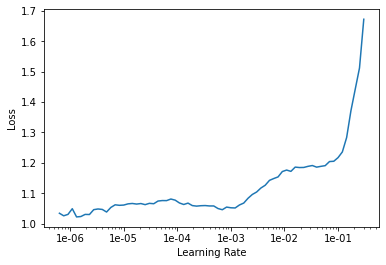

In [19]:
learn_img.unfreeze()
learn_img.lr_find()
learn_img.recorder.plot()

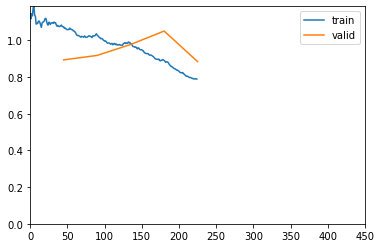

Better model found at epoch 0 with valid_loss value: 0.8941493034362793.
Epoch 1: reducing lr to 0.000152
Epoch 2: reducing lr to 0.00020000000000000006
Epoch 3: reducing lr to 0.00019009692640269477
Epoch 4: early stopping
Better model found at epoch 4 with valid_loss value: 0.8846008777618408.


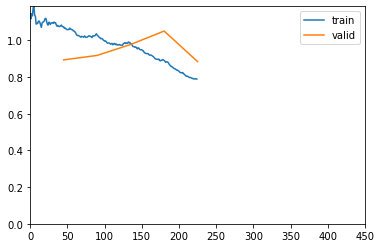

In [20]:
learn_img.fit_one_cycle(10, slice(1e-4, 1e-3),callbacks=[SaveModelCallback(learn_img,every='improvement', monitor='valid_loss', name='best')])

In [21]:
learn_img.validate(data_img.valid_dl,metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.8846009,
 tensor(0.6772),
 tensor(0.5041),
 tensor(0.6550),
 tensor(0.4417),
 tensor(0.6772),
 tensor(0.4553),
 tensor(0.6626)]

In [22]:
interp = ClassificationInterpretation.from_learner(learn_img)

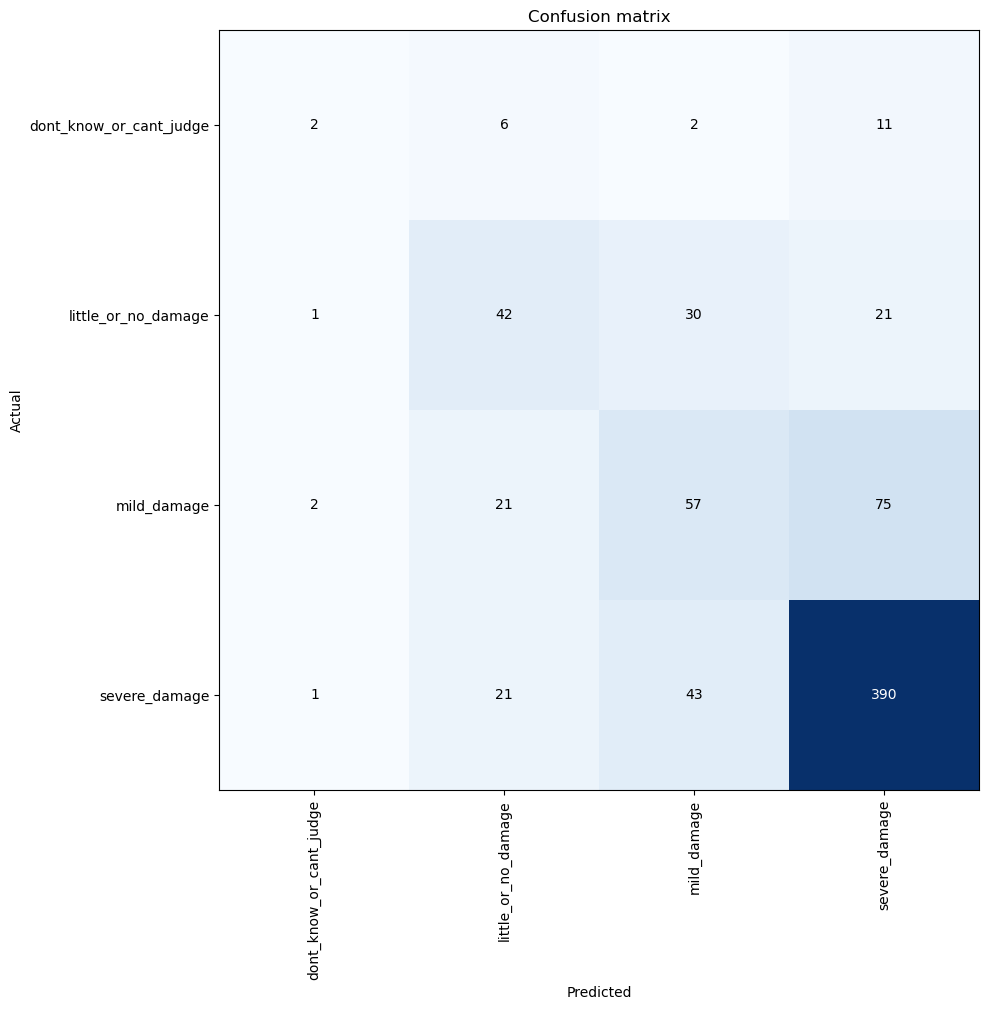

In [23]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=100)

In [24]:
preds,y,losses = learn_img.get_preds(with_loss=True)

y_preds = preds.argmax(1)

In [25]:
target_names = ['severe_damage','mild_damage','little_or_no_damage','dont_know_or_cant_judge']

print(classification_report(y, y_preds, target_names=target_names))

                         precision    recall  f1-score   support

          severe_damage       0.33      0.10      0.15        21
            mild_damage       0.47      0.45      0.46        94
    little_or_no_damage       0.43      0.37      0.40       155
dont_know_or_cant_judge       0.78      0.86      0.82       455

               accuracy                           0.68       725
              macro avg       0.50      0.44      0.46       725
           weighted avg       0.65      0.68      0.66       725

